# 1. Importing the neccesary libraries and packages

In [83]:
import os
import numpy as np
import shutil
import random
import zipfile
import matplotlib.pyplot as plt
from tabulate import tabulate
import itertools
from numpy.random import seed
seed(1337)
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models, optimizers
from keras.models import Sequential

# Import the VGG16_Model
from keras.applications.vgg16 import VGG16

# Import the MobileNet model 
from keras.applications.mobilenet import MobileNet

# Import the DenseNet201 model 
from keras.applications.densenet import DenseNet201

# Import the ResNet 50 model
from keras.applications.resnet import ResNet50


# 2. Defining the necessary Functions

In [84]:
def model_summary(base_model,nb_categories=10):
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Dense(nb_categories, activation='softmax'))
    flatten_layer = layers.Flatten()
    dense_layer_1 = layers.Dense(1024, activation='relu')
    prediction_layer = layers.Dense(10, activation='softmax')
    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer_1,
        prediction_layer
    ])
    for i, layer in enumerate(model.layers):
        print(i, layer.name, layer.trainable)
        print(model.summary())
    return model

In [85]:
def learning_curves_plot(model):
    plt.rcParams["figure.figsize"] = (12,7)
    acc = model.history['acc']
    val_acc = model.history['val_acc']
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    epochs = range(1,len(acc)+1)
    plt.figure()
    plt.plot(epochs, acc, 'b', label = 'Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.savefig('Accuracy.jpg')
    plt.figure()
    plt.plot(epochs, loss, 'b', label = 'Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig('Loss.jpg')

In [86]:
def plot_confusion_matrix(cm, classes, figname,normalize=False,title='Confusion matrix', cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    plt.rcParams["figure.figsize"] = (20,10)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment='center',
        color='white' if cm[i, j] > thresh else 'black')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig(figname)

In [87]:
def Calculate_ConfMatrix(model):   
    Y_pred = model.predict_generator(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    cm = confusion_matrix(test_generator.classes, y_pred)
    return cm, y_pred
  

In [88]:
learning_rate = 5e-5

def Fine_Tuning_Network(epchos,pretrainedModel):
    checkpoint = ModelCheckpoint("sign_classifier.h5", monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    pretrainedModel.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate, clipnorm = 1.), metrics = ['acc'])

    model_hist = pretrainedModel.fit_generator(train_generator, 
                                  epochs=epochs, 
                                  shuffle=True, 
                                  validation_data=val_generator,
                                  callbacks=[checkpoint]
                                  )
    return model_hist, pretrainedModel

# 3. Load Dataset  & Split into training,validation and testing 


In [89]:
base_folder='......./ML_Task/'

#Unzip Dataset File
with zipfile.ZipFile(base_folder+"EuroSAT.zip", 'r') as zip_ref:
    zip_ref.extractall(base_folder)

In [90]:
root_dir = base_folder+"/2750/" # for requesting directly pics
classes_dir = os.listdir(root_dir)

#Set an input destination for Training, Validation and Testing Datasets
input_destination = base_folder


train_ratio = 0.7
val_ratio  = 0.15

for cls in classes_dir:
    os.makedirs(input_destination +'train_ds/' + cls, exist_ok=True)
    os.makedirs(input_destination +'test_ds/' + cls, exist_ok=True)
    os.makedirs(input_destination +'val_ds/' + cls, exist_ok=True)
    
    # for each class, let's counts its elements
    src = root_dir + cls
    allFileNames = os.listdir(src)

    # shuffle it and split into train/test/va
    np.random.shuffle(allFileNames)
    train_FileNames, test_FileNames, val_FileNames = np.split(np.array(allFileNames),[int(train_ratio * len(allFileNames)), int((1-val_ratio) * len(allFileNames))])
    
    # save their initial path
    train_FileNames = [src+'/'+ name  for name in train_FileNames.tolist()]
    test_FileNames  = [src+'/' + name for name in test_FileNames.tolist()]
    val_FileNames   = [src+'/' + name for name in val_FileNames.tolist()]
    print("\n *****************************",
          "\n Total images: ",cls, len(allFileNames),
          '\n Training: ', len(train_FileNames),
          '\n Testing: ', len(test_FileNames),
          '\n Validation: ', len(val_FileNames),
          '\n *****************************')
    
    # copy files from the initial path to the final folders
    for name in train_FileNames:
      shutil.copy(name, input_destination +'train_ds/' + cls)
    for name in test_FileNames:
      shutil.copy(name, input_destination +'test_ds/' + cls)
    for name in val_FileNames:
      shutil.copy(name, input_destination +'val_ds/' + cls)


# checking everything was fine
paths = ['train_ds/', 'test_ds/','val_ds/']
for p in paths:
  for dir,subdir,files in os.walk(input_destination + p):
    print(dir,' ', p, str(len(files)))


 ***************************** 
 Total images:  AnnualCrop 3000 
 Training:  2100 
 Testing:  450 
 Validation:  450 
 *****************************

 ***************************** 
 Total images:  Forest 3000 
 Training:  2100 
 Testing:  450 
 Validation:  450 
 *****************************

 ***************************** 
 Total images:  HerbaceousVegetation 3000 
 Training:  2100 
 Testing:  450 
 Validation:  450 
 *****************************

 ***************************** 
 Total images:  Highway 2500 
 Training:  1750 
 Testing:  375 
 Validation:  375 
 *****************************

 ***************************** 
 Total images:  Industrial 2500 
 Training:  1750 
 Testing:  375 
 Validation:  375 
 *****************************

 ***************************** 
 Total images:  Pasture 2000 
 Training:  1400 
 Testing:  300 
 Validation:  300 
 *****************************

 ***************************** 
 Total images:  PermanentCrop 2500 
 Training:  1750 
 Testing:  37

# 4. Loading training,validation and testing dataset


In [91]:
train_data_dir = os.path.join(input_destination, 'train_ds')
val_data_dir = os.path.join(input_destination, 'val_ds')
test_data_dir = os.path.join(input_destination, 'test_ds')

category_names = sorted(os.listdir(train_data_dir))
print('We have 10 classes in our dataset :',category_names)

# folder for storing models

outFldModels = 'Store_Models'
path = os.path.join(input_destination, outFldModels)
# Create the directory
# 'Store_Models' in 'root_dir'
os.mkdir(path)
print("outFldModels '% s' created" % outFldModels)

#Number of images to load at each iteration
batch_size = 64

# only rescaling
train_datagen =  ImageDataGenerator(rescale=1./255)
test_datagen =  ImageDataGenerator(rescale=1./255)

# these are generators for train/test data that will read pictures 
img_height, img_width = 64,64
print('Total number of images for "training":')
train_generator = train_datagen.flow_from_directory(train_data_dir,target_size = (img_height, img_width),batch_size = batch_size, class_mode = "categorical")
print('Total number of images for "validation":')
val_generator = test_datagen.flow_from_directory(val_data_dir,target_size = (img_height, img_width),batch_size = batch_size,class_mode = "categorical",shuffle=False)
print('Total number of images for "testing":')
test_generator = test_datagen.flow_from_directory(test_data_dir,target_size = (img_height, img_width),batch_size = batch_size,class_mode = "categorical",shuffle=False)

We have 10 classes in our dataset : ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
outFldModels 'Store_Models' created
Total number of images for "training":
Found 18900 images belonging to 10 classes.
Total number of images for "validation":
Found 4050 images belonging to 10 classes.
Total number of images for "testing":
Found 4050 images belonging to 10 classes.


## - Calculate and plot the proportional distribution of the datasets 

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake', 'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake', 'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


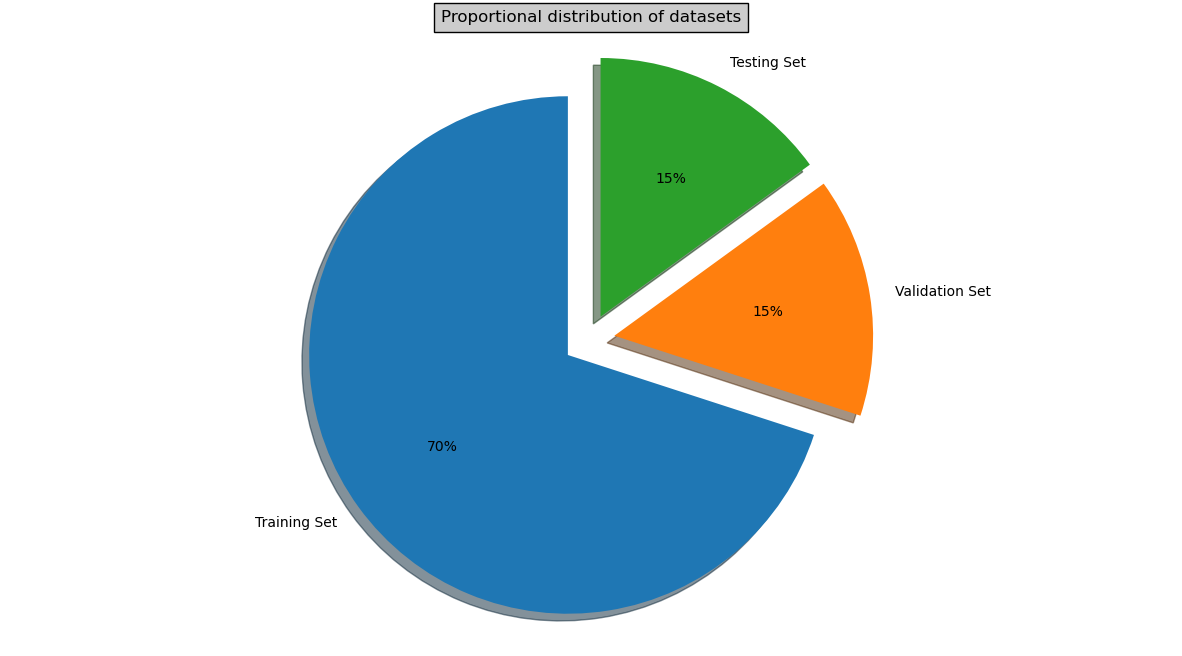

In [92]:

nb_categories = len(category_names)
img_pr_cat = []
img_pr_cat1 = []
img_pr_cat2 = []

for category in category_names:
    folder = train_data_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
    folder1 = val_data_dir + '/' + category
    img_pr_cat1.append(len(os.listdir(folder1)))
    folder2 = test_data_dir + '/' + category
    img_pr_cat2.append(len(os.listdir(folder2)))

a=list(img_pr_cat+img_pr_cat1+img_pr_cat2)
b=list(category_names*3)
print(b)


labels = ['Training Set', 'Validation Set', 'Testing Set']
data=[((img_pr_cat[0])*2),((img_pr_cat1[0])*2),((img_pr_cat2[0])*2)]
 
# Creating plot
plt.rcParams["figure.figsize"] = (15,8)

explode = (0.1, 0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(data, explode=explode, labels=labels, autopct='%1.0f%%',
        shadow=True, startangle=90)

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportional distribution of datasets', bbox={'facecolor':'0.8', 'pad':5})

# show plot
plt.show()

## - Plot an example image from each category

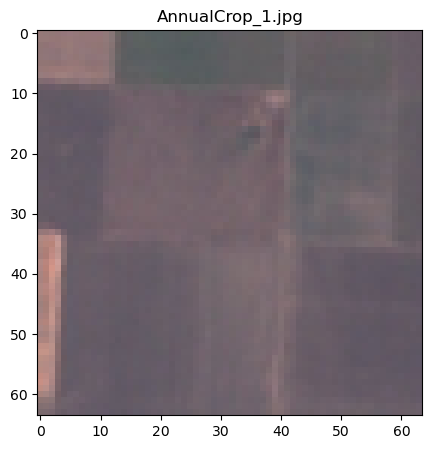

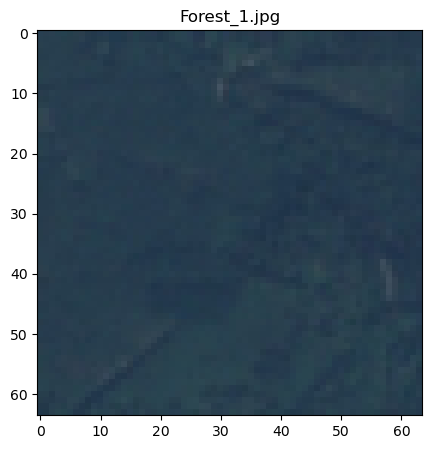

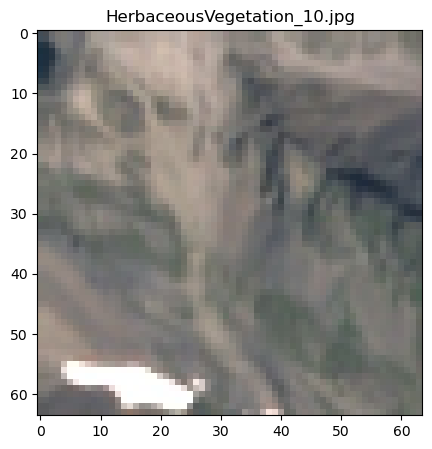

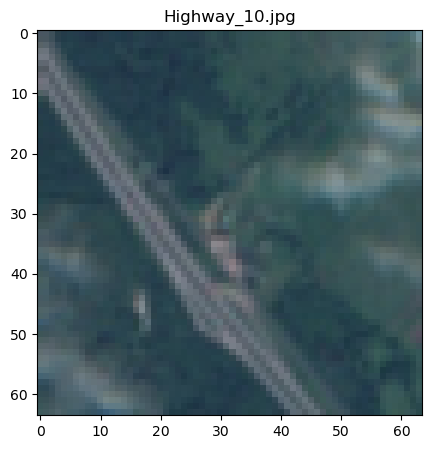

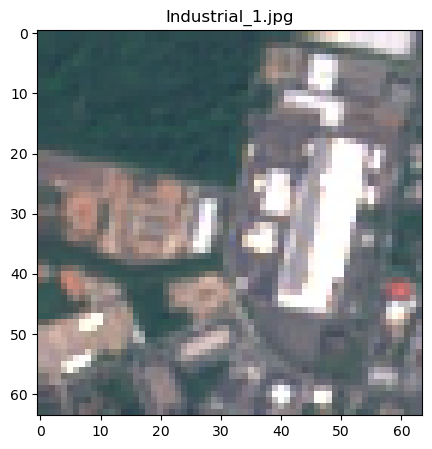

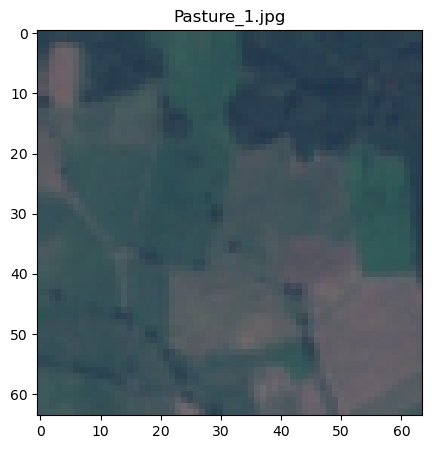

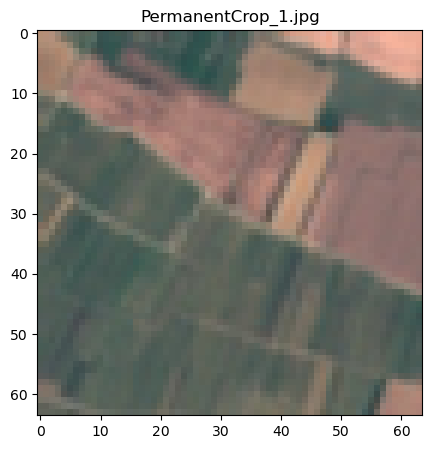

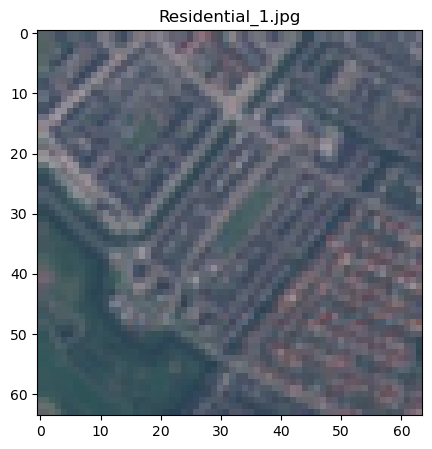

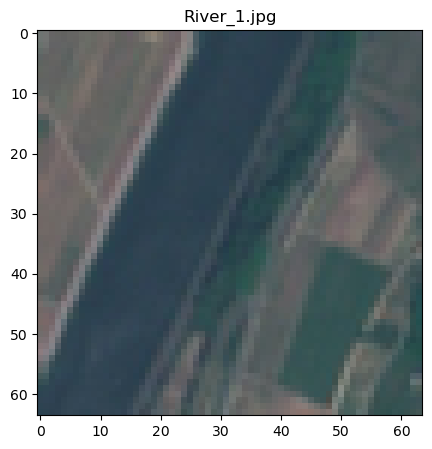

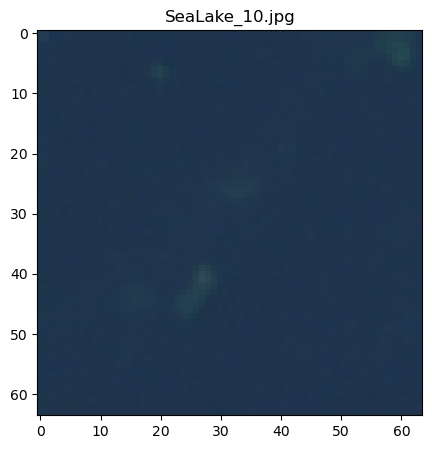

In [94]:
# We plot these examples in order to visualize the typical image quality
for subdir, dirs, files in os.walk(train_data_dir):
    for file in files:
        img_file = subdir + '/' + file
        image = load_img(img_file)
        plt.rcParams["figure.figsize"] = (15,5)
        plt.figure()
        plt.title(file)
        plt.imshow(image)
        break
plt.show()

# 5. Implementation of the Tranfer Learning Models

## 5.1. VGG16 Model

###  5.1.a VGG16: Preparing a transfer learning network 

In [95]:
## Loading VGG16 model
base_model_VGG16 = VGG16(weights='imagenet', include_top=False, pooling='max', input_shape = (img_width, img_height, 3))
base_model_VGG16.summary()

# Make sure you have frozen the correct layers
for i, layer in enumerate(base_model_VGG16.layers):
    print(i, layer.name, layer.trainable)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [96]:
pretrained_modelVGG16=model_summary(base_model_VGG16,10)

0 vgg16 True
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 1024)              525312    
                                                                 
 dense_14 (Dense)            (None, 10)                10250     
                                                                 
Total params: 15,250,250
Trainable params: 15,250,250
Non-trainable params: 0
_________________________________________________________________
None
1 flatten_4 True
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape          

### 5.1.b. VGG16: Fine Tuning Network

In [97]:
#Define the epoch parameter and start training
epochs = 10

modelVGG16_hist_1, modelVGG16_1 = Fine_Tuning_Network(epochs,pretrained_modelVGG16)

C:\Users\nourd\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\nourd\AppData\Local\Temp\ipykernel_17992\3221606180.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_hist = pretrainedModel.fit_generator(train_generator,


Epoch 1/10
296/296 [==============================] - ETA: 0s - loss: 0.5023 - acc: 0.8262
Epoch 1: val_acc improved from -inf to 0.92667, saving model to sign_classifier.h5
296/296 [==============================] - 2941s 10s/step - loss: 0.5023 - acc: 0.8262 - val_loss: 0.2100 - val_acc: 0.9267
Epoch 2/10
296/296 [==============================] - ETA: 0s - loss: 0.1977 - acc: 0.9335 
Epoch 2: val_acc improved from 0.92667 to 0.93630, saving model to sign_classifier.h5
296/296 [==============================] - 3076s 10s/step - loss: 0.1977 - acc: 0.9335 - val_loss: 0.1809 - val_acc: 0.9363
Epoch 3/10
296/296 [==============================] - ETA: 0s - loss: 0.1371 - acc: 0.9515
Epoch 3: val_acc improved from 0.93630 to 0.94395, saving model to sign_classifier.h5
296/296 [==============================] - 2719s 9s/step - loss: 0.1371 - acc: 0.9515 - val_loss: 0.1643 - val_acc: 0.9440
Epoch 4/10
296/296 [==============================] - ETA: 0s - loss: 0.1064 - acc: 0.9640
Epoch 4: 

### 5.1.c VGG16: Saving the Model

In [98]:
modelVGG16_1.save(outFldModels+'/VGG16_model_E10')

INFO:tensorflow:Assets written to: Store_Models/VGG16_model_E10\assets


INFO:tensorflow:Assets written to: Store_Models/VGG16_model_E10\assets


### 5.1.d VGG16: Loading the Model

In [99]:
modelVGG16_Trained_1 = models.load_model(outFldModels+'/VGG16_model_E10')

#modelVGG16_Trained.summary()

In [100]:
modelVGG16_Trained_1.get_config()

{'name': 'sequential_9',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 64, 64, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'vgg16_input'}},
  {'class_name': 'Functional',
   'config': {'name': 'vgg16',
    'layers': [{'class_name': 'InputLayer',
      'config': {'batch_input_shape': (None, 64, 64, 3),
       'dtype': 'float32',
       'sparse': False,
       'ragged': False,
       'name': 'input_5'},
      'name': 'input_5',
      'inbound_nodes': []},
     {'class_name': 'Conv2D',
      'config': {'name': 'block1_conv1',
       'trainable': True,
       'dtype': 'float32',
       'filters': 64,
       'kernel_size': (3, 3),
       'strides': (1, 1),
       'padding': 'same',
       'data_format': 'channels_last',
       'dilation_rate': (1, 1),
       'groups': 1,
       'activation': 'relu',
       'use_bias': True,
       'kernel_initializer': {'class_name': 'GlorotUniform',
        'config': {'seed': None}}

### 5.1.e VGG16: Evaluation of the model accuracy

#### - Plot the learning curves

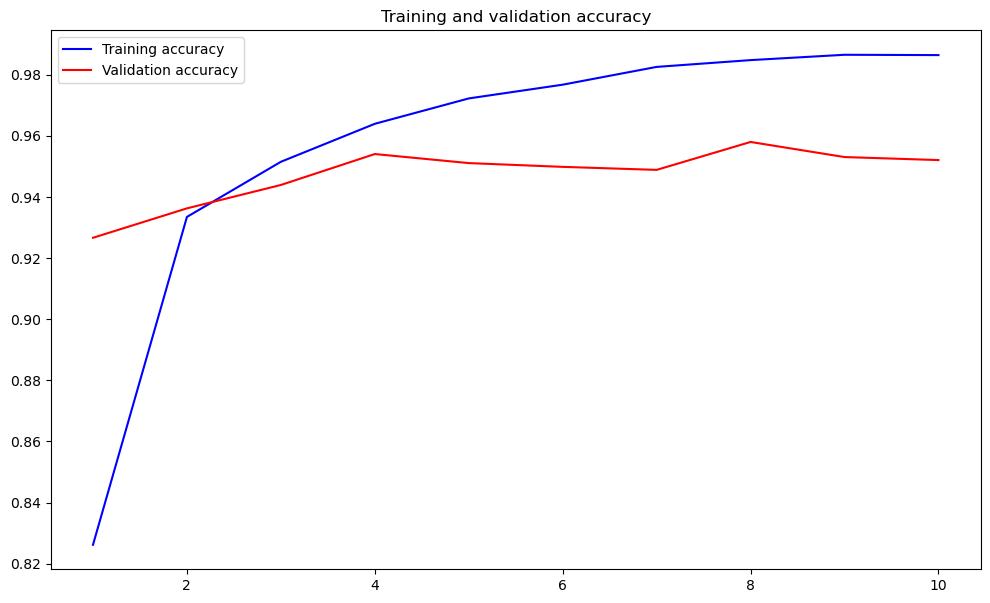

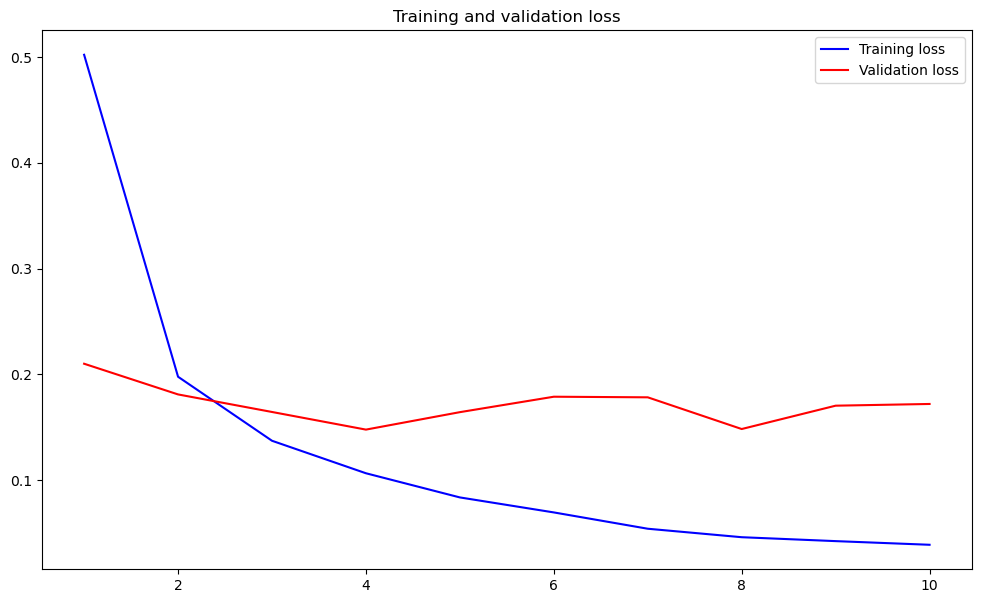

In [101]:
learning_curves_plot(modelVGG16_hist_1)
plt.show()

#### - Calculate and plot confusion matrix

C:\Users\nourd\AppData\Local\Temp\ipykernel_17992\3083333466.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator)


Confusion matrix, without normalization


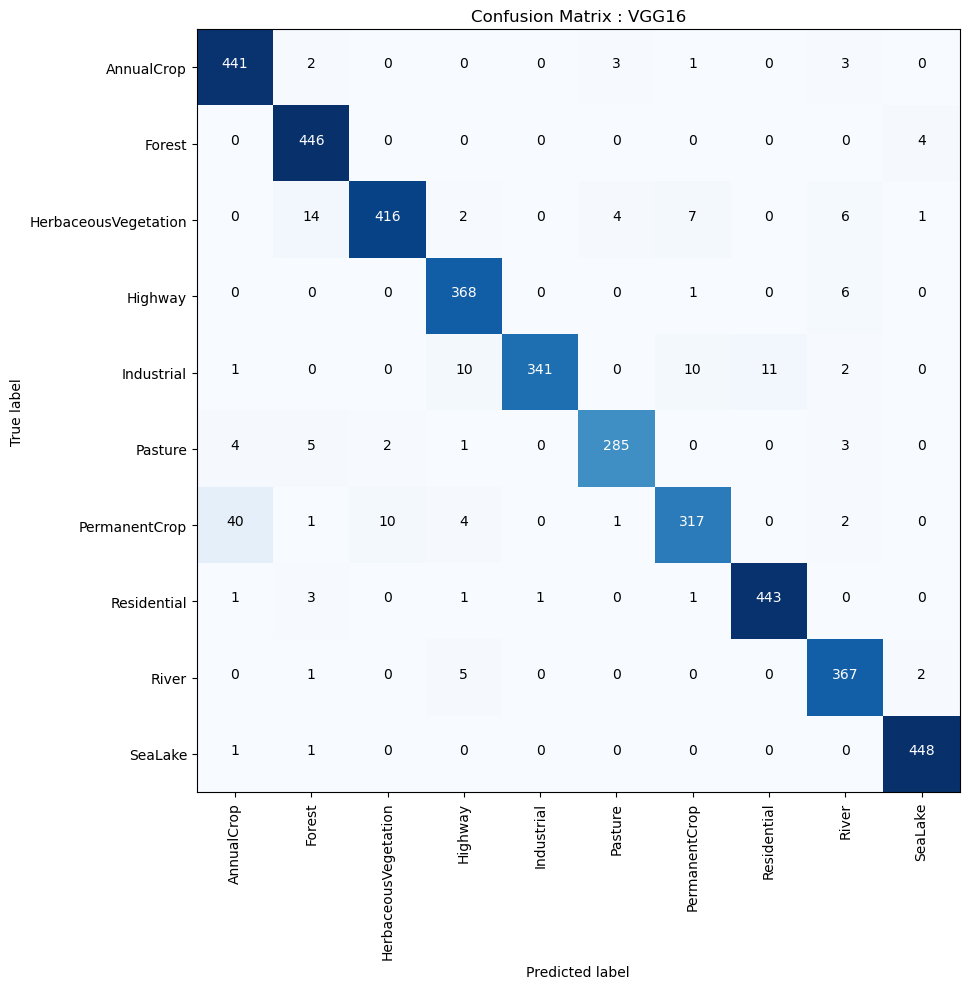

In [102]:
cm_VGG16_1, y_pred_VGG16_1=Calculate_ConfMatrix(modelVGG16_Trained_1)    
plot_confusion_matrix(cm_VGG16_1, classes = category_names, title='Confusion Matrix : VGG16', normalize=False, figname = 'Confusion_matrix_concrete.jpg')
plt.show()

#### - Calculate the final accuracy

In [103]:
accuracy_VGG16_1 = accuracy_score(test_generator.classes, y_pred_VGG16_1)
print("Accuracy in test set: %0.1f%% " % (accuracy_VGG16_1 * 100))

Accuracy in test set: 95.6% 


## 5.2. Model_MobileNet

### 5.2.a MobileNet: Preparing a transfer learning network

In [104]:
## Loading MobileNet model
base_model_MobileNet = MobileNet(weights='imagenet', include_top=False, pooling='max', input_shape = (img_width, img_height, 3))
base_model_MobileNet.summary()


for layer in base_model_MobileNet.layers:
    layer.trainable=False

# Make sure you have frozen the correct layers
for i, layer in enumerate(base_model_MobileNet.layers):
    print(i, layer.name, layer.trainable)

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 32, 32, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 32, 32, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 32, 32, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 32, 32, 32)       128       
 ation)                                         

In [105]:
pretrained_modelMobileNet=model_summary(base_model_MobileNet,10)

0 mobilenet_1.00_224 True
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1024)             3228864   
 nal)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 1024)              0         
                                                                 
 dense_16 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_17 (Dense)            (None, 10)                10250     
                                                                 
Total params: 4,288,714
Trainable params: 1,059,850
Non-trainable params: 3,228,864
_________________________________________________________________
None
1 flatten_5 True
Model: "sequential_11"
______________________________

### 5.2.b. MobileNet: Fine Tuning Network

In [106]:
#Define the epoch parameter and start training
epochs = 10

modelMobileNet_hist_1, modelMobileNet_1 = Fine_Tuning_Network(epochs,pretrained_modelMobileNet)

C:\Users\nourd\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\nourd\AppData\Local\Temp\ipykernel_17992\3221606180.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_hist = pretrainedModel.fit_generator(train_generator,


Epoch 1/10
296/296 [==============================] - ETA: 0s - loss: 1.1450 - acc: 0.6489
Epoch 1: val_acc improved from -inf to 0.77185, saving model to sign_classifier.h5
296/296 [==============================] - 131s 432ms/step - loss: 1.1450 - acc: 0.6489 - val_loss: 0.7577 - val_acc: 0.7719
Epoch 2/10
296/296 [==============================] - ETA: 0s - loss: 0.6417 - acc: 0.8061
Epoch 2: val_acc improved from 0.77185 to 0.80889, saving model to sign_classifier.h5
296/296 [==============================] - 86s 292ms/step - loss: 0.6417 - acc: 0.8061 - val_loss: 0.6206 - val_acc: 0.8089
Epoch 3/10
296/296 [==============================] - ETA: 0s - loss: 0.5249 - acc: 0.8373
Epoch 3: val_acc improved from 0.80889 to 0.82074, saving model to sign_classifier.h5
296/296 [==============================] - 87s 294ms/step - loss: 0.5249 - acc: 0.8373 - val_loss: 0.5691 - val_acc: 0.8207
Epoch 4/10
296/296 [==============================] - ETA: 0s - loss: 0.4597 - acc: 0.8580
Epoch 4:

### 5.2.c MobileNet: Saving the Model

In [107]:
modelMobileNet_1.save(outFldModels+'/MobileNet_model_E10')

INFO:tensorflow:Assets written to: Store_Models/MobileNet_model_E10\assets


INFO:tensorflow:Assets written to: Store_Models/MobileNet_model_E10\assets


### 5.2.d MobileNet: Loading the Model 

In [108]:
modelMobileNet_Trained_1 = models.load_model(outFldModels+'/MobileNet_model_E10')
modelMobileNet_Trained_1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1024)             3228864   
 nal)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 1024)              0         
                                                                 
 dense_16 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_17 (Dense)            (None, 10)                10250     
                                                                 
Total params: 4,288,714
Trainable params: 1,059,850
Non-trainable params: 3,228,864
_________________________________________________________________


In [109]:
modelMobileNet_Trained_1.get_config()

{'name': 'sequential_11',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 64, 64, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'mobilenet_1.00_224_input'}},
  {'class_name': 'Functional',
   'config': {'name': 'mobilenet_1.00_224',
    'layers': [{'class_name': 'InputLayer',
      'config': {'batch_input_shape': (None, 64, 64, 3),
       'dtype': 'float32',
       'sparse': False,
       'ragged': False,
       'name': 'input_6'},
      'name': 'input_6',
      'inbound_nodes': []},
     {'class_name': 'Conv2D',
      'config': {'name': 'conv1',
       'trainable': False,
       'dtype': 'float32',
       'filters': 32,
       'kernel_size': (3, 3),
       'strides': (2, 2),
       'padding': 'same',
       'data_format': 'channels_last',
       'dilation_rate': (1, 1),
       'groups': 1,
       'activation': 'linear',
       'use_bias': False,
       'kernel_initializer': {'class_name': 'GlorotUniform',
        '

### 5.2.e MobileNet: Evaluation of the model accuracy

#### - Plot the learning curves

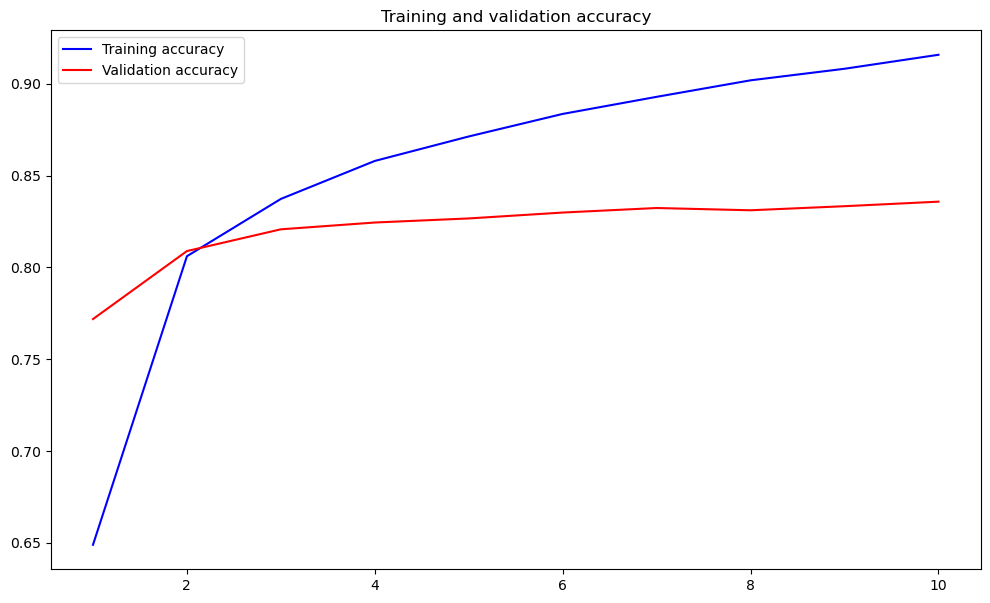

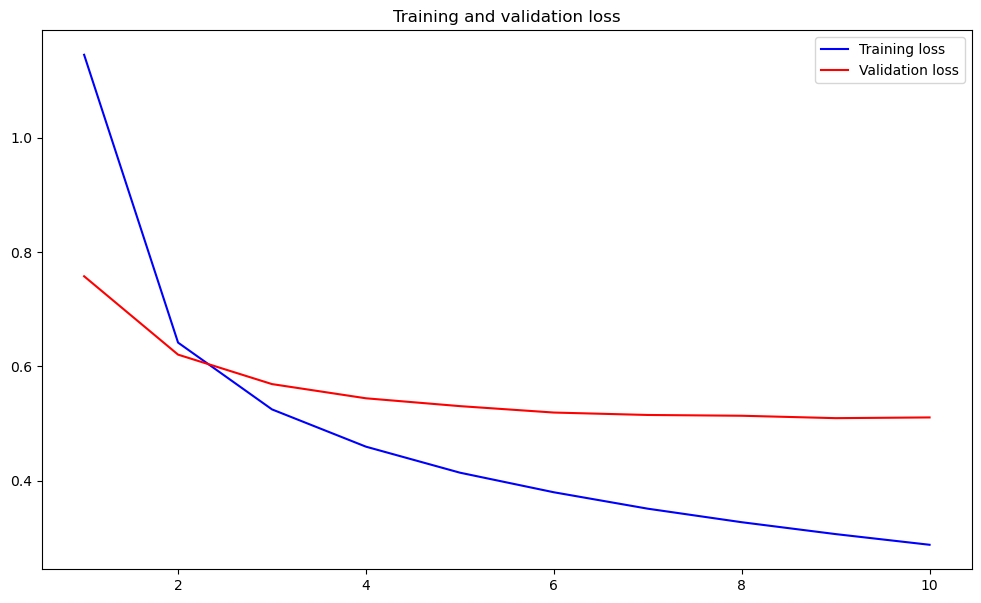

In [110]:
learning_curves_plot(modelMobileNet_hist_1)
plt.show()

#### - Calculate and plot confusion matrix

C:\Users\nourd\AppData\Local\Temp\ipykernel_17992\3083333466.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator)


Confusion matrix, without normalization


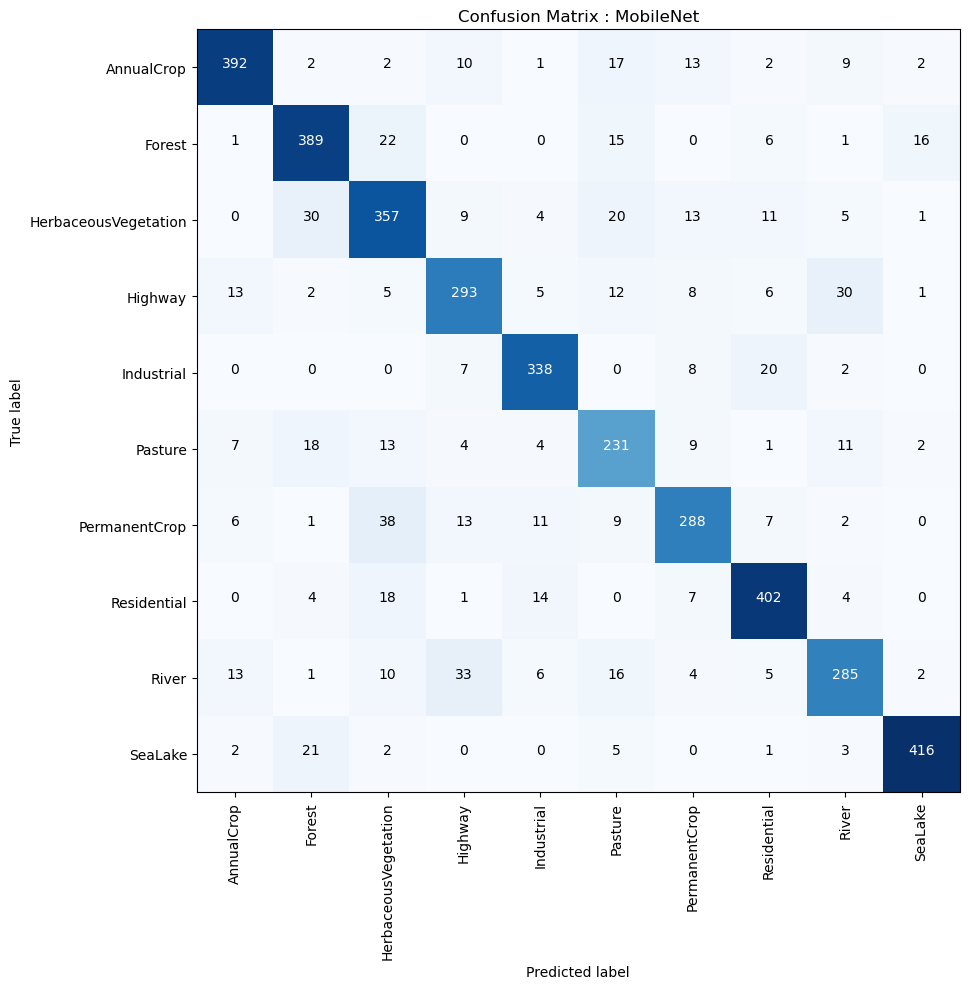

In [111]:
cm_MobileNet_1, y_pred_MobileNet_1=Calculate_ConfMatrix(modelMobileNet_Trained_1)   
plot_confusion_matrix(cm_MobileNet_1, classes = category_names, title='Confusion Matrix : MobileNet', normalize=False, figname = 'Confusion_matrix_concrete.jpg') 
plt.show()

#### - Calculate the final accuracy

In [112]:
accuracy_MobileNet_1 = accuracy_score(test_generator.classes, y_pred_MobileNet_1)
print("Accuracy in test set: %0.1f%% " % (accuracy_MobileNet_1 * 100))

Accuracy in test set: 83.7% 


## 5.3. Model_DenseNet201

### 5.3.a DenseNet201: Preparing a transfer learning network

In [113]:
## Loading DenseNet201 model
base_model_DenseNet201 = DenseNet201(weights='imagenet', include_top=False, pooling='max', input_shape = (img_width, img_height, 3))
base_model_DenseNet201.summary()


for layer in base_model_DenseNet201.layers:
    layer.trainable=False

# Make sure you have frozen the correct layers
for i, layer in enumerate(base_model_DenseNet201.layers):
    print(i, layer.name, layer.trainable)

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 70, 70, 3)   0           ['input_7[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 32, 32, 64)   9408        ['zero_padding2d_2[0][0]']       
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1/conv[0][0]']   

In [114]:
pretrained_modelDenseNet201=model_summary(base_model_DenseNet201,10)

0 densenet201 True
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 flatten_6 (Flatten)         (None, 1920)              0         
                                                                 
 dense_19 (Dense)            (None, 1024)              1967104   
                                                                 
 dense_20 (Dense)            (None, 10)                10250     
                                                                 
Total params: 20,299,338
Trainable params: 1,977,354
Non-trainable params: 18,321,984
_________________________________________________________________
None
1 flatten_6 True
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output

### 5.3.b. DenseNet201: Fine Tuning Network

In [115]:
#Define the epoch parameter and start training
epochs = 10

modelDenseNet201_hist_1, modelDenseNet201_1 = Fine_Tuning_Network(epochs,pretrained_modelDenseNet201)

C:\Users\nourd\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\nourd\AppData\Local\Temp\ipykernel_17992\3221606180.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_hist = pretrainedModel.fit_generator(train_generator,


Epoch 1/10
296/296 [==============================] - ETA: 0s - loss: 0.8061 - acc: 0.7488
Epoch 1: val_acc improved from -inf to 0.85037, saving model to sign_classifier.h5
296/296 [==============================] - 599s 2s/step - loss: 0.8061 - acc: 0.7488 - val_loss: 0.4735 - val_acc: 0.8504
Epoch 2/10
296/296 [==============================] - ETA: 0s - loss: 0.3917 - acc: 0.8767
Epoch 2: val_acc improved from 0.85037 to 0.87926, saving model to sign_classifier.h5
296/296 [==============================] - 573s 2s/step - loss: 0.3917 - acc: 0.8767 - val_loss: 0.3729 - val_acc: 0.8793
Epoch 3/10
296/296 [==============================] - ETA: 0s - loss: 0.3043 - acc: 0.9055
Epoch 3: val_acc improved from 0.87926 to 0.89235, saving model to sign_classifier.h5
296/296 [==============================] - 718s 2s/step - loss: 0.3043 - acc: 0.9055 - val_loss: 0.3336 - val_acc: 0.8923
Epoch 4/10
296/296 [==============================] - ETA: 0s - loss: 0.2557 - acc: 0.9207
Epoch 4: val_ac

### 5.3.c DenseNet201: Saving the Model 

In [116]:
modelDenseNet201_1.save(outFldModels+'/DenseNet201_model_E10')

INFO:tensorflow:Assets written to: Store_Models/DenseNet201_model_E10\assets


INFO:tensorflow:Assets written to: Store_Models/DenseNet201_model_E10\assets


### 5.3.d DenseNet201: Loading the Model


In [117]:
modelDenseNet201_Trained_1 = models.load_model(outFldModels+'/DenseNet201_model_E10')
modelDenseNet201_Trained_1.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 flatten_6 (Flatten)         (None, 1920)              0         
                                                                 
 dense_19 (Dense)            (None, 1024)              1967104   
                                                                 
 dense_20 (Dense)            (None, 10)                10250     
                                                                 
Total params: 20,299,338
Trainable params: 1,977,354
Non-trainable params: 18,321,984
_________________________________________________________________


In [118]:
modelDenseNet201_Trained_1.get_config()

{'name': 'sequential_13',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 64, 64, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'densenet201_input'}},
  {'class_name': 'Functional',
   'config': {'name': 'densenet201',
    'layers': [{'class_name': 'InputLayer',
      'config': {'batch_input_shape': (None, 64, 64, 3),
       'dtype': 'float32',
       'sparse': False,
       'ragged': False,
       'name': 'input_7'},
      'name': 'input_7',
      'inbound_nodes': []},
     {'class_name': 'ZeroPadding2D',
      'config': {'name': 'zero_padding2d_2',
       'trainable': False,
       'dtype': 'float32',
       'padding': ((3, 3), (3, 3)),
       'data_format': 'channels_last'},
      'name': 'zero_padding2d_2',
      'inbound_nodes': [[['input_7', 0, 0, {}]]]},
     {'class_name': 'Conv2D',
      'config': {'name': 'conv1/conv',
       'trainable': False,
       'dtype': 'float32',
       'filters': 64,
       'kern

### 5.3.e DenseNet201: Evaluation of the model accuracy

#### - Plot the learning curves

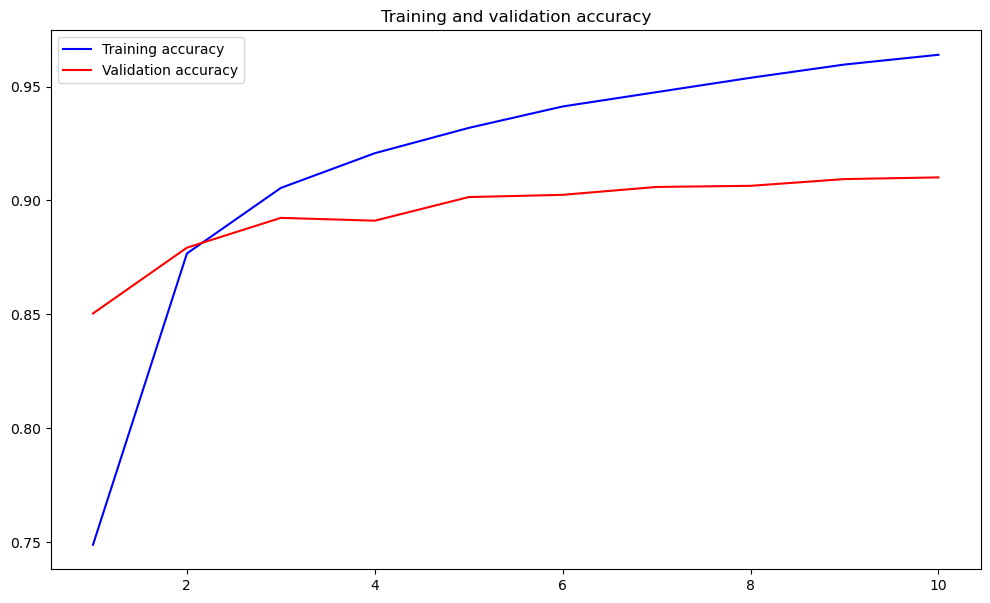

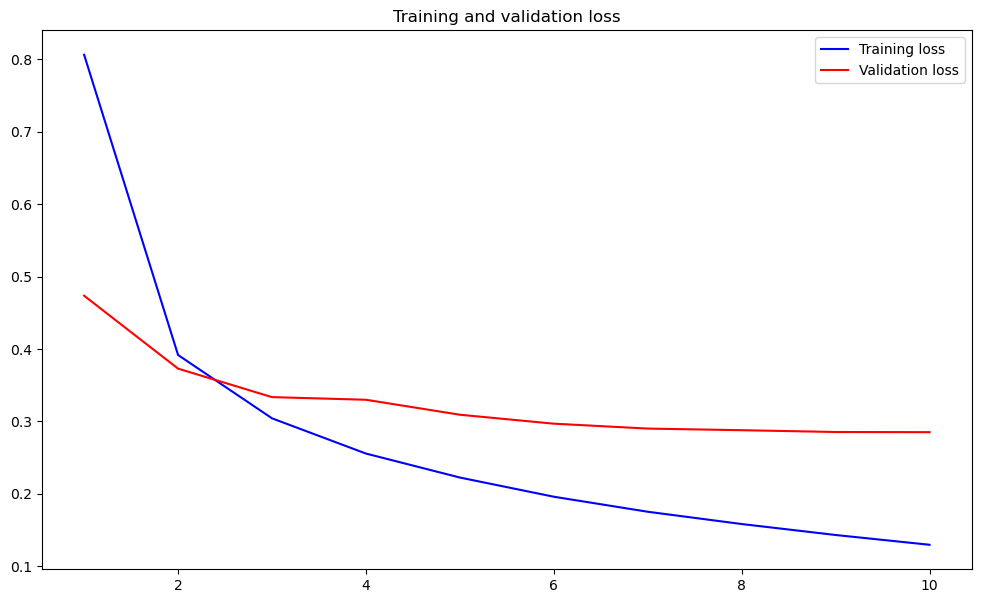

In [119]:
learning_curves_plot(modelDenseNet201_hist_1)
plt.show()

#### - Calculate and plot confusion matrix

C:\Users\nourd\AppData\Local\Temp\ipykernel_17992\3083333466.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator)


Confusion matrix, without normalization


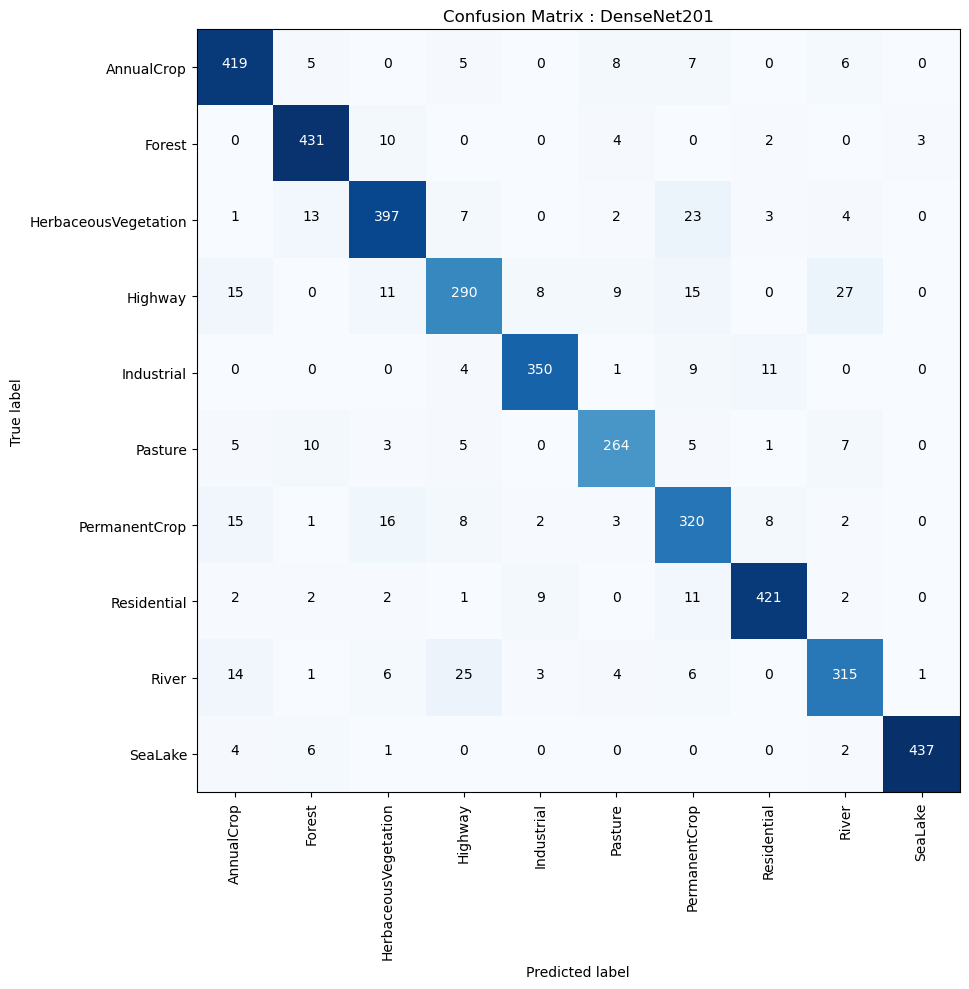

In [120]:
cm_DenseNet201_1, y_pred_DenseNet201_1=Calculate_ConfMatrix(modelDenseNet201_Trained_1)   
plot_confusion_matrix(cm_DenseNet201_1, classes = category_names, title='Confusion Matrix : DenseNet201', normalize=False, figname = 'Confusion_matrix_concrete.jpg')
plt.show()

#### - Calculate the final accuracy

In [121]:
accuracy_DenseNet201_1 = accuracy_score(test_generator.classes, y_pred_DenseNet201_1)
print("Accuracy in test set: %0.1f%% " % (accuracy_DenseNet201_1 * 100))

Accuracy in test set: 90.0% 


## 5.4. Model_Resnet50

### 5.4.a ResNet50: Preparing a transfer learning network

In [122]:
## Loading Resnet50 model
base_model_ResNet50 = ResNet50(weights='imagenet', include_top=False, pooling='max', input_shape = (img_width, img_height, 3))
base_model_ResNet50.summary()


for layer in base_model_ResNet50.layers:
    layer.trainable=False

# Make sure you have frozen the correct layers
for i, layer in enumerate(base_model_ResNet50.layers):
    print(i, layer.name, layer.trainable)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [123]:
pretrained_modelResNet50=model_summary(base_model_ResNet50,10)

0 resnet50 True
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_22 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_23 (Dense)            (None, 10)                10250     
                                                                 
Total params: 25,696,138
Trainable params: 2,108,426
Non-trainable params: 23,587,712
_________________________________________________________________
None
1 flatten_7 True
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Sh

### 5.4.b. ResNet50: Fine Tuning Network

In [124]:
#Define the epoch parameter and start training
epochs = 10

modelResNet50_hist_1, modelResNet50_1 = Fine_Tuning_Network(epochs,pretrained_modelResNet50)

C:\Users\nourd\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\nourd\AppData\Local\Temp\ipykernel_17992\3221606180.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_hist = pretrainedModel.fit_generator(train_generator,


Epoch 1/10
296/296 [==============================] - ETA: 0s - loss: 2.1667 - acc: 0.2472
Epoch 1: val_acc improved from -inf to 0.31284, saving model to sign_classifier.h5
296/296 [==============================] - 343s 1s/step - loss: 2.1667 - acc: 0.2472 - val_loss: 2.0370 - val_acc: 0.3128
Epoch 2/10
296/296 [==============================] - ETA: 0s - loss: 1.9577 - acc: 0.3449
Epoch 2: val_acc improved from 0.31284 to 0.33975, saving model to sign_classifier.h5
296/296 [==============================] - 326s 1s/step - loss: 1.9577 - acc: 0.3449 - val_loss: 1.8883 - val_acc: 0.3398
Epoch 3/10
296/296 [==============================] - ETA: 0s - loss: 1.8315 - acc: 0.3781
Epoch 3: val_acc improved from 0.33975 to 0.40716, saving model to sign_classifier.h5
296/296 [==============================] - 341s 1s/step - loss: 1.8315 - acc: 0.3781 - val_loss: 1.7807 - val_acc: 0.4072
Epoch 4/10
296/296 [==============================] - ETA: 0s - loss: 1.7428 - acc: 0.4011
Epoch 4: val_ac

### 5.4.c ResNet50: Saving the Model

In [125]:
modelResNet50_1.save(outFldModels+'/ResNet50_model_E10')

INFO:tensorflow:Assets written to: Store_Models/ResNet50_model_E10\assets


INFO:tensorflow:Assets written to: Store_Models/ResNet50_model_E10\assets


### 5.4.d ResNet50: Loading the Model

In [126]:
modelResNet50_Trained_1 = models.load_model(outFldModels+'/ResNet50_model_E10')
modelResNet50_Trained_1.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_22 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_23 (Dense)            (None, 10)                10250     
                                                                 
Total params: 25,696,138
Trainable params: 2,108,426
Non-trainable params: 23,587,712
_________________________________________________________________


In [127]:
modelResNet50_Trained_1.get_config()

{'name': 'sequential_15',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 64, 64, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'resnet50_input'}},
  {'class_name': 'Functional',
   'config': {'name': 'resnet50',
    'layers': [{'class_name': 'InputLayer',
      'config': {'batch_input_shape': (None, 64, 64, 3),
       'dtype': 'float32',
       'sparse': False,
       'ragged': False,
       'name': 'input_8'},
      'name': 'input_8',
      'inbound_nodes': []},
     {'class_name': 'ZeroPadding2D',
      'config': {'name': 'conv1_pad',
       'trainable': False,
       'dtype': 'float32',
       'padding': ((3, 3), (3, 3)),
       'data_format': 'channels_last'},
      'name': 'conv1_pad',
      'inbound_nodes': [[['input_8', 0, 0, {}]]]},
     {'class_name': 'Conv2D',
      'config': {'name': 'conv1_conv',
       'trainable': False,
       'dtype': 'float32',
       'filters': 64,
       'kernel_size': (7, 7),
  

### 5.4.e ResNet50: Evaluation of the model accuracy

#### - Plot the learning curves

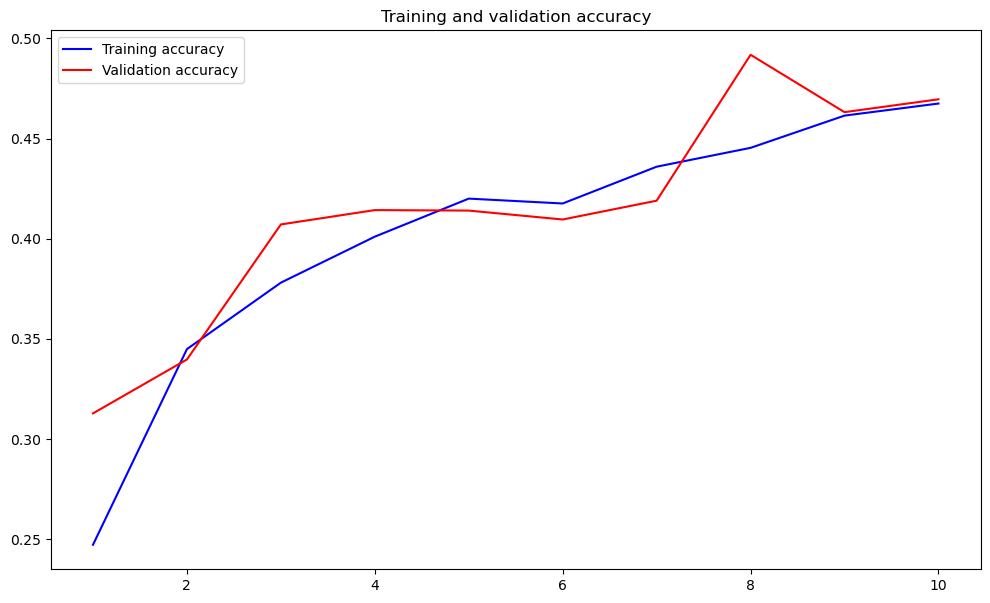

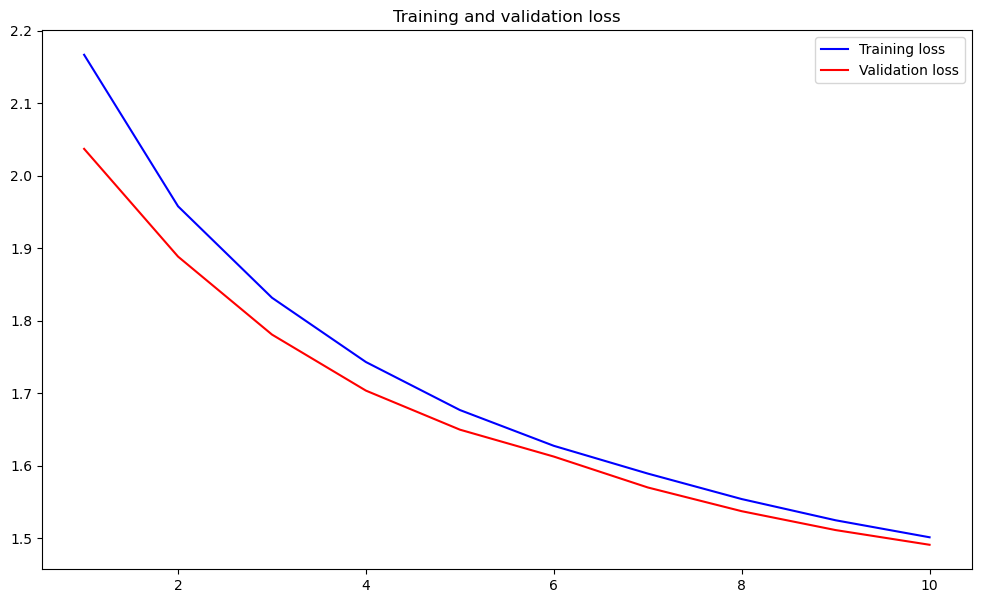

In [128]:
learning_curves_plot(modelResNet50_hist_1)
plt.show()

#### - Calculate and plot confusion matrix

C:\Users\nourd\AppData\Local\Temp\ipykernel_17992\3083333466.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator)


Confusion matrix, without normalization


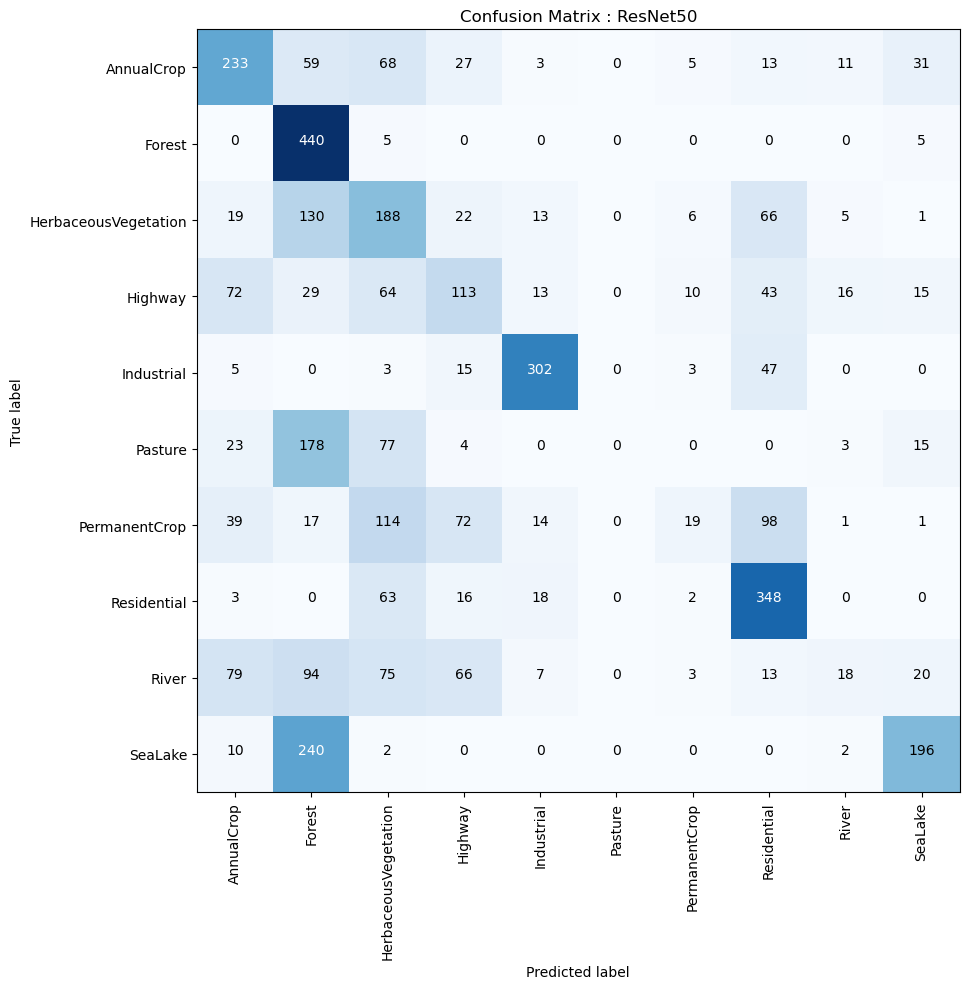

In [129]:
cm_ResNet50_1, y_pred_ResNet50_1=Calculate_ConfMatrix(modelResNet50_Trained_1)    
plot_confusion_matrix(cm_ResNet50_1, classes = category_names, title='Confusion Matrix : ResNet50', normalize=False, figname = 'Confusion_matrix_concrete.jpg')
plt.show()

#### - Calculate the final accuracy

In [130]:
accuracy_ResNet50_1 = accuracy_score(test_generator.classes, y_pred_ResNet50_1)
print("Accuracy in test set: %0.1f%% " % (accuracy_ResNet50_1 * 100))

Accuracy in test set: 45.9% 


# 6. Comparaison of models' accuracies

In [131]:
#create data

data =  [["VGG16", "%0.1f%% " % (accuracy_VGG16_1 * 100)], 
        ["MobileNet", "%0.1f%% " % (accuracy_MobileNet_1 * 100)],
        ["DenseNet201","%0.1f%% " % (accuracy_DenseNet201_1 * 100)],
        ["Xception","%0.1f%% " % (accuracy_ResNet50_1 * 100)]]
  
    

#define header names
col_names = ["Model Name", "Accuracy Value"]
  
#display table
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒══════════════╤══════════════════╕
│ Model Name   │ Accuracy Value   │
╞══════════════╪══════════════════╡
│ VGG16        │ 95.6%            │
├──────────────┼──────────────────┤
│ MobileNet    │ 83.7%            │
├──────────────┼──────────────────┤
│ DenseNet201  │ 90.0%            │
├──────────────┼──────────────────┤
│ Xception     │ 45.9%            │
╘══════════════╧══════════════════╛


## - Using Bar Chart 

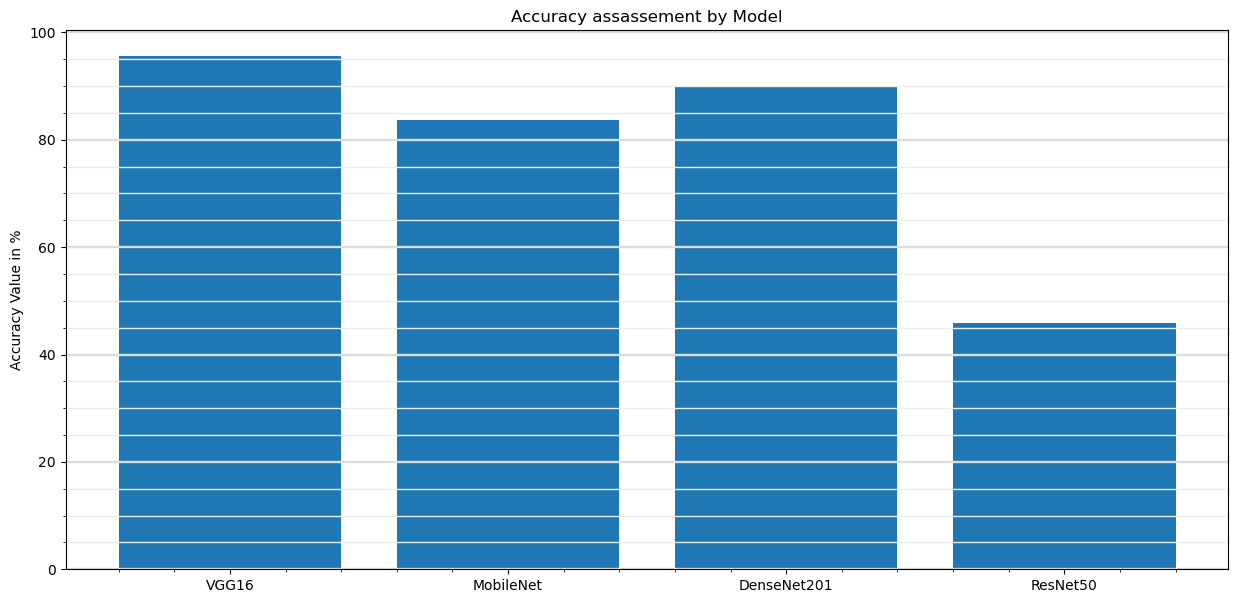

In [132]:
plt.rcParams["figure.figsize"] = (15,7)
fig, ax = plt.subplots()

Models = ['VGG16','MobileNet','DenseNet201', 'ResNet50']
Models_accuracy = [accuracy_VGG16_1*100, accuracy_MobileNet_1*100,accuracy_DenseNet201_1*100,accuracy_ResNet50_1*100]
ax.bar(Models, Models_accuracy, label=Models)

ax.set_ylabel('Accuracy Value in %')
ax.set_title('Accuracy assassement by Model')
ax.grid(axis = 'y',which='major', color='#DDDDDD', linewidth=1.7)
# Show the minor grid as well. Style it in very light gray as a thin,
# dotted line.
ax.grid(axis = 'y',which='minor', color='#EEEEEE', linestyle='-', linewidth=1)
# Make the minor ticks and gridlines show.
ax.minorticks_on()
plt.show()